<a href="https://colab.research.google.com/github/bbenip/tetris-ai/blob/main/model/rl/rl_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Default title text
MOUNT_DRIVE = True # @param {type:"boolean"}
CLONE_REPO = False # @param {type:"boolean"}
CONNECT_TPU = False # @param {type:"boolean"}


In [2]:
if MOUNT_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')

  %cd drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [3]:
if CLONE_REPO:
  !git clone https://github.com/bbenip/tetris-ai.git tetris-ai

fatal: destination path 'tetris-ai' already exists and is not an empty directory.


In [4]:
  %cd tetris-ai/model/rl

/content/drive/MyDrive/tetris-ai/model/rl


In [5]:
!git pull

Already up to date.


In [6]:
import tensorflow as tf

In [7]:
if CONNECT_TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

In [8]:
import os
#Cloud TPUs can only save to GCP Buckets but we can use the tmp directory to get around that
if CONNECT_TPU:
  CHECKPOINT_DIR = "/tmp/training_checkpoints"
  CHECKPOINT_PREFIX = "tpu-ckpt"
  CHECKPOINT_OPTS = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
else:
  CHECKPOINT_DIR = "./training_checkpoints"
  CHECKPOINT_PREFIX = "ckpt"
  CHECKPOINT_OPTS = None

CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, CHECKPOINT_PREFIX)

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, InputLayer

In [10]:
def create_model():
  # Define the input for the CNN branch
  board_input = Input(shape=(21, 10, 1), name='board_input')
  current_piece_input = Input(shape=(4, 4, 1), name='current_piece_input')
  next_piece_input = Input(shape=(4, 4, 1), name='next_piece_input')
  position_input = Input(shape=(2), name="position_input")
  line_height_input = Input(shape=(1), name="line_height_input")

  # Create the CNN branch
  board_branch = Conv2D(256, (3, 3), activation='relu')(board_input)
  board_branch = MaxPooling2D((2, 2), padding='same')(board_branch)
  board_branch = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu)(board_branch)
  board_branch = MaxPooling2D((2, 2), padding='same')(board_branch)
  board_branch = Flatten()(board_branch)

  current_branch = Flatten()(current_piece_input)

  next_branch = Flatten()(next_piece_input)

  # Concatenate the 3 branches + position
  concatenated_inputs = concatenate([board_branch,
                                     current_branch,
                                     next_branch,
                                     position_input,
                                     line_height_input],
                                    name='concatenated_inputs')

  # Create the dense branch for the concatenated inputs
  dense_branch = Dense(64, activation=tf.nn.leaky_relu)(concatenated_inputs)
  dense_branch = Dense(32, activation='relu')(dense_branch)

  # Create the output layer
  output = Dense(6, activation='linear', name='output')(dense_branch)

  # Define the model with 4 inputs and one output
  model = tf.keras.Model(inputs=[board_input,
                                 current_piece_input,
                                 next_piece_input,
                                 position_input,
                                 line_height_input],
                         outputs=output)

  # Define the optimizer and loss function based on your RL task.
  optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)  # Adjust the learning rate as needed.
  loss_fn = tf.keras.losses.MeanSquaredError()  # Adjust the loss function as needed.

  # Compile the model.
  model.compile(optimizer=optimizer, loss=loss_fn)

  return model

In [11]:
from random import sample
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

In [12]:
import numpy as np


class SumTree(object):

    def __init__(self, capacity):
        self.capacity = capacity
        # number of nodes in the tree
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0
        self.write = 0

    # leaf node retrieval function
    # idx - index of the top-parent node as the first arguments
    # value - random sampled value
    def retrieve(self, idx, value):

        # left/right - left/right idx of elements following after idx
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if value <= self.tree[left]:
            return self.retrieve(left, value)
        else:
            return self.retrieve(right, value - self.tree[left])

    # update priority
    def update(self, idx, new_value):

        change = new_value - self.tree[idx]
        self.tree[idx] = new_value
        self.propagate_changes(idx, change)

    def propagate_changes(self, idx, change):

        # calculate parent id
        parent = (idx - 1) // 2
        self.tree[parent] += change

        # if we not in root propogate changes
        if parent != 0:
            self.propagate_changes(parent, change)

    def add(self, value, data):

        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, value)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # get priority and sample
    def get(self, value):

        idx = self.retrieve(0, value)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

    def total(self):
        return self.tree[0]

In [13]:
import random
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=1.0, epsilon=0.0):
        self.capacity = capacity
        self.tree = SumTree(capacity)
        self.alpha = alpha  # Prioritization hyperparameter (0 = uniform sampling, 1 = full prioritization)
        self.beta = beta
        self.epsilon = epsilon

    def get_size(self):
        return self.tree.n_entries

    def add_experience(self, experience, priority):
        self.tree.add(priority, experience)

    def sample_batch(self, batch_size):
        batch = []
        segment = self.tree.total() / batch_size
        priorities = []
        idxs = []

        for i in range(batch_size):
            a = i * segment
            b = (i + 1) * segment
            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)

        # Calculate sampling probabilities for importance sampling weights
        sampling_probabilities = priorities / self.tree.total()
        is_weights = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weights /= is_weights.max()

        return idxs, batch, is_weights

    def update_priorities(self, indices, td_errors):
        for i, error in zip(indices, td_errors):
            priority = (error + self.epsilon) ** self.alpha
            self.tree.update(i, priority)

In [19]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

def getInputFromState(state):
    model_input = state[:]
    model_input[0] = tf.reshape(model_input[0], (1, 21, 10, 1))
    model_input[1] = tf.expand_dims(tf.expand_dims(model_input[1], -1), 0)
    model_input[2] = tf.expand_dims(tf.expand_dims(model_input[2], -1), 0)
    return model_input

def dqn(env,
        num_episodes,
        batch_size,
        gamma,
        ε_start,
        ε_end,
        ε_decay_steps,
        replay_buffer,
        learning_rate):
    episode = tf.Variable(0)

    current_step = 0
    scores = np.zeros(NUM_EPISODES)
    move_counts = np.zeros(NUM_EPISODES)
    avg_score = np.zeros(NUM_EPISODES)
    avg_moves = np.zeros(NUM_EPISODES)

    model = create_model()  # Define the DQN neural network.
    target_model = create_model()  # Target network for stability.

    checkpoint = tf.train.Checkpoint(episode=episode, model=model, target_model=target_model)
    status = checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR), options=CHECKPOINT_OPTS)

    while episode < NUM_EPISODES:
        score = 0
        moves = 0
        count = 0

        env.start_game()
        state = getInputFromState(env.getState())
        done = False
        while not done and moves < MAX_MOVES:
          if current_step < ε_decay_steps:
            # Update epsilon using linear decay
            epsilon = max(ε_end, ε_start - (ε_start - ε_end) * (current_step / ε_decay_steps))

          q_values = model(state)
          # Epsilon-greedy action selection
          if np.random.rand() < epsilon:
              action = np.random.randint(6)  # Explore
              #print(f"Random Action: {action}")
          else:
              action = tf.argmax(q_values).numpy()[0]
              #print(f"Action: {action}")

          next_state, reward, done = env.doAction(action)
          next_state = getInputFromState(next_state)

          next_state_q_values = target_model(next_state)
          max_next_q_value = tf.reduce_max(next_state_q_values)
          target_q_value = reward + gamma + max_next_q_value
          td_error = tf.abs(target_q_value - q_values[0, action])

          replay_buffer.add_experience((state, action, reward, next_state, done), td_error)#.append((state, action, reward, next_state, done))
          state = next_state

          count += 1
          moves += 1
          score += reward if reward > 0 else 0
          # Sample and train on mini-batch from replay buffer
          if replay_buffer.get_size() >= batch_size and count >= batch_size:
              count = 0
              memory_idxs, mini_batch, is_weights = replay_buffer.sample_batch(batch_size)
              train_dqn(model,
                        target_model,
                        replay_buffer.update_priorities,
                        memory_idxs,
                        mini_batch,
                        is_weights,
                        gamma,
                        learning_rate)

        scalar_episode = int(episode)

        scores[scalar_episode] = score
        move_counts[scalar_episode] = moves

        start_idx = max(0, scalar_episode - 16)
        avg_score[scalar_episode] = np.average(scores[start_idx:scalar_episode])
        avg_moves[scalar_episode] = np.average(move_counts[start_idx: scalar_episode])

        if episode > 0 and episode % EPISODES_PER_CHECKPOINT == 0:
            checkpoint.save(file_prefix=CHECKPOINT_PATH)

        if episode > 0 and episode % EPISODES_PER_UPDATE == 0:
            clear_output(wait=True)
            print(f"Episode: {episode}")
            print(f"Average Score (Past 16 games): {avg_score[scalar_episode]}")
            print(f"Average Moves (Past 16 games): {avg_moves[scalar_episode]}")

            x_range = np.arange(scalar_episode)

            fig, (ax1, ax2) = plt.subplots(2, 1)

            color = 'tab:red'
            ax1.set_xlabel('Episode')
            ax1.set_ylabel('Score', color=color)
            ax1.scatter(x_range, scores[:scalar_episode], color=color)
            ax1.plot(x_range, avg_score[:scalar_episode], color="black", linewidth=2, label='avg_score')
            ax1.tick_params(axis='y', labelcolor=color)

            color = 'tab:blue'
            ax2.set_xlabel('Episode')
            ax2.set_ylabel('Moves', color=color)
            ax2.scatter(x_range, move_counts[:scalar_episode], color=color)
            ax2.plot(x_range, avg_moves[:scalar_episode], color="black", linewidth=2, label='avg_moves')
            ax2.tick_params(axis='y', labelcolor=color)

            fig.tight_layout()
            plt.show()

        episode.assign_add(1)
        current_step +=1


In [20]:
import numpy as np
import tensorflow as tf

def train_dqn(model, target_model, update_prio_fn, memory_idxs, mini_batch, is_weights, gamma, learning_rate):
    # Step 1: Compute the target Q-values using the target model
    states, actions, rewards, next_states, dones = zip(*mini_batch)

    # Convert to tensors
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)

    next_inputs = []
    for inputs in zip(*next_states):
      next_inputs.append(tf.concat(inputs, 0))

    model_inputs = []
    for inputs in zip(*states):
      model_inputs.append(tf.concat(inputs, 0))

    next_q_values = target_model(next_inputs)
    max_next_q_values = tf.reduce_max(next_q_values, axis=-1)
    target_q_values = gamma * max_next_q_values + tf.cast(rewards, tf.float32)
    # target_q_values = np.expand_dims(target_q_values, axis=1)  # Add an extra dimension for broadcasting

    # print("Curr pieces ", model_inputs[1].shape)
    # print("Boards ", model_inputs[0].shape)

    # Masking to only compare the q-values of actions taken
    mask = tf.one_hot(actions, 6)

    # Update the model's weights using gradient descent to minimize the loss
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    with tf.GradientTape() as tape:
      predicted_q_values = model(model_inputs, training=True)
      predicted_q_values = tf.reduce_sum(mask * predicted_q_values, axis=-1)

      loss = tf.keras.losses.mean_squared_error(target_q_values, predicted_q_values)
      loss = tf.reduce_mean(loss * is_weights)

      gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    td_errors = tf.abs(predicted_q_values - target_q_values)
    update_prio_fn(memory_idxs, td_errors)
    return loss.numpy().mean()


In [21]:
# @title Training Constants
NUM_EPISODES = 1024 # @param {type:"integer"}
MAX_MOVES = 1024 # @param {type:"integer"}
BATCH_SIZE = 256 # @param {type:"integer"}
DISCOUNT_FACTOR = 0.86 # @param {type:"slider", min:0, max:1, step:0.01}
EXPLORATION_START = 0.8 # @param {type:"slider", min:0, max:1, step:0.1}
EXPLORATION_END = 0.1 # @param {type:"slider", min:0, max:1, step:0.1}
E_DECAY_STEPS = 512 # @param {type:"integer"}
LEARNING_RATE = 0.001 # @param {type:"number"}

EPISODES_PER_UPDATE = 32 # @param {type:"integer"}
EPISODES_PER_CHECKPOINT = 256 # @param {type:"integer"}

INVALID_MOVE_REWARD = -999 # @param {type:"integer"}
GAME_OVER_REWARD = -887 # @param {type:"integer"}
VALID_MOVE_REWARD = 0 # @param {type:"integer"}
STACK_HEIGHT_PENALTY = 10 # @param {type:"integer"}
ROTATION_PENALTY = 20 # @param {type:"integer"}

In [22]:
REPLAY_BUFFER_SIZE = 1000000 # @param {type:"integer"}
REPLAY_ALPHA = 0.7 # @param {type:"number"}
REPLAY_BETA = 0.5 # @param {type:"number"}
REPLAY_EPSILON = 0.01 # @param {type:"number"}

replay_buffer = PrioritizedReplayBuffer(capacity=REPLAY_BUFFER_SIZE,
                                        alpha=REPLAY_ALPHA,
                                        beta=REPLAY_BETA,
                                        epsilon=REPLAY_EPSILON)

Episode: <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=512>
Average Score (Past 16 games): 31.125
Average Moves (Past 16 games): 625.4375


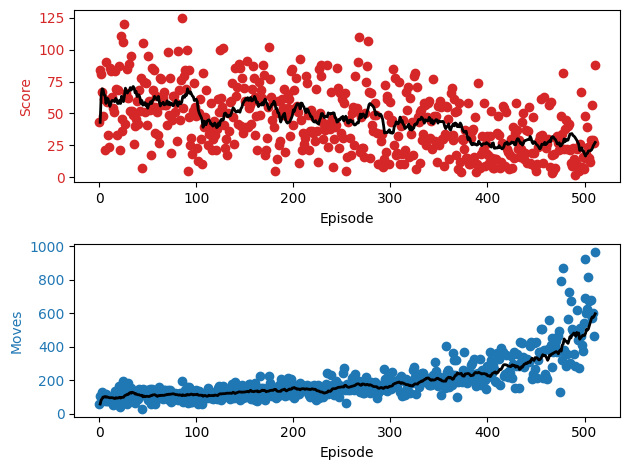

KeyboardInterrupt: ignored

In [23]:
from tetris import TetrisApp

REWARDS = (INVALID_MOVE_REWARD,
           GAME_OVER_REWARD,
           VALID_MOVE_REWARD,
           STACK_HEIGHT_PENALTY,
           ROTATION_PENALTY)
env = TetrisApp(ai=True, rewards=REWARDS)
dqn(env,
    num_episodes=NUM_EPISODES,
    batch_size=BATCH_SIZE,
    ε_start=EXPLORATION_START,
    ε_end=EXPLORATION_END,
    ε_decay_steps=E_DECAY_STEPS,
    replay_buffer=replay_buffer,
    gamma=DISCOUNT_FACTOR,
    learning_rate=LEARNING_RATE)